In [1]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from unidecode import unidecode
import datetime as dt
import requests
import statsapi


In [ ]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

In [89]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [68]:
#data20_22 = pd.concat([data20_22,data23])
#data23 = statcast()

start_dt 2024-06-24
end_dt 2024-06-25
This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [90]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

In [91]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]

In [92]:
data20_22['p_throws'] = data20_22['p_throws'].map({'L': 0, 'R': 1})
data23['p_throws'] = data23['p_throws'].map({'L': 0, 'R': 1})

data20_22['stand'] = data20_22['stand'].map({'L': 0, 'R': 1})
data23['stand'] = data23['stand'].map({'L': 0, 'R': 1})

In [93]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [94]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [95]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [96]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [97]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)


#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['spin_axis'] = (df['spin_axis']+ 180) % 360
    df['calc_spin'] = np.arctan2(df['pfx_z'],df['pfx_x']) * (180 / np.pi)
    df['axis_dif'] = np.minimum(
        np.abs(df['spin_axis'] - df['calc_spin']),
        360 - np.abs(df['spin_axis'] - df['calc_spin'])
    )
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)


def find_most_common_fastball(df):
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)


In [98]:
data23[['spin_axis','calc_spin','axis_dif']]

,spin_axis,calc_spin,axis_dif
0,206.0,-141.709837,12.290163
1,26.0,76.429566,50.429566
2,204.0,-140.622401,15.377599
3,24.0,68.008870,44.008870
4,27.0,85.207966,58.207966
...,...,...,...
719313,14.0,84.836693,70.836693
719314,21.0,73.839853,52.839853
719315,13.0,81.573031,68.573031
719316,14.0,81.107451,67.107451


In [99]:
# Combining Fastball, Sinker, and Cutter into one dataframe
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]

# Combining Slider and Sweeper into one dataframe
breakingball_20_22 = data20_22[data20_22.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]
breakingball_23 = data23[data23.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]

# Combining Changeup and Splitter into one dataframe
offspeed_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup', 'Splitter'])]
offspeed_23 = data23[data23.pitch_type.isin(['Changeup', 'Splitter'])]

In [100]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff','game_year']
fball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif','game_year']

In [101]:
#Split into train and test

fastball_x = fastball_20_22[fball_features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

breakingball_x = breakingball_20_22[features]
breakingball_y = breakingball_20_22['delta_run_exp']

x_train_breakingball, x_test_breakingball, y_train_breakingball, y_test_breakingball = train_test_split(breakingball_x, breakingball_y, train_size=0.75, random_state=12345)

offspeed_x = offspeed_20_22[features]
offspeed_y = offspeed_20_22['delta_run_exp']

x_train_offspeed, x_test_offspeed, y_train_offspeed, y_test_offspeed = train_test_split(offspeed_x, offspeed_y, train_size=0.75, random_state=12345)



In [102]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
breakingball_model = CatBoostRegressor(**params)
breakingball_model.fit(x_train_breakingball, y_train_breakingball)

#Cutter
offspeed_model = CatBoostRegressor(**params)
offspeed_model.fit(x_train_offspeed, y_train_offspeed)

0:	learn: 0.2452046	total: 41.4ms	remaining: 20.7s
1:	learn: 0.2451997	total: 62.7ms	remaining: 15.6s
2:	learn: 0.2451914	total: 83.3ms	remaining: 13.8s
3:	learn: 0.2451838	total: 103ms	remaining: 12.8s
4:	learn: 0.2451772	total: 124ms	remaining: 12.3s
5:	learn: 0.2451724	total: 145ms	remaining: 11.9s
6:	learn: 0.2451671	total: 164ms	remaining: 11.5s
7:	learn: 0.2451620	total: 185ms	remaining: 11.4s
8:	learn: 0.2451589	total: 204ms	remaining: 11.1s
9:	learn: 0.2451555	total: 223ms	remaining: 10.9s
10:	learn: 0.2451515	total: 242ms	remaining: 10.8s
11:	learn: 0.2451480	total: 262ms	remaining: 10.6s
12:	learn: 0.2451447	total: 282ms	remaining: 10.6s
13:	learn: 0.2451416	total: 301ms	remaining: 10.5s
14:	learn: 0.2451385	total: 320ms	remaining: 10.3s
15:	learn: 0.2451354	total: 338ms	remaining: 10.2s
16:	learn: 0.2451322	total: 355ms	remaining: 10.1s
17:	learn: 0.2451290	total: 374ms	remaining: 10s
18:	learn: 0.2451261	total: 392ms	remaining: 9.93s
19:	learn: 0.2451242	total: 411ms	remain

In [103]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])

breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])

offspeed_23['pred'] = offspeed_model.predict(offspeed_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_15573/3149739183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_15573/3149739183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_15573/3149739183.py:6: SettingWithCopyWarni

In [104]:
combined_df = pd.concat([fastball_23, breakingball_23, offspeed_23])

def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(combined_df)

fastball_23 = combined_df[combined_df.pitch_type == 'Fastball']
sinker_23 = combined_df[combined_df.pitch_type == 'Sinker']
cutter_23 = combined_df[combined_df.pitch_type == 'Cutter']
slider_23 = combined_df[combined_df.pitch_type == 'Slider']
sweeper_23 = combined_df[combined_df.pitch_type == 'Sweeper']
curveball_23 = combined_df[combined_df.pitch_type == 'Curveball']
changeup_23 = combined_df[combined_df.pitch_type == 'Changeup']
splitter_23 = combined_df[combined_df.pitch_type == 'Splitter']


In [105]:
def calculate_mean_scores_for_graphic(df):
    mean_scores = df.groupby('player_name')[['score','release_speed','pfx_x', 'pfx_z','release_pos_x','release_pos_z','release_extension']].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

fastball_graphic_data = calculate_mean_scores_for_graphic(fastball_23)
sinker_graphic_data = calculate_mean_scores_for_graphic(sinker_23)
slider_graphic_data = calculate_mean_scores_for_graphic(slider_23)
sweeper_graphic_data = calculate_mean_scores_for_graphic(sweeper_23)
curveball_graphic_data = calculate_mean_scores_for_graphic(curveball_23)
changeup_graphic_data = calculate_mean_scores_for_graphic(changeup_23)
splitter_graphic_data = calculate_mean_scores_for_graphic(splitter_23)

def mean_release(df):
    mean_scores = df[['release_pos_x','release_pos_z','release_extension']].mean().reset_index()
    return mean_scores

fastball_graphic_release_data = calculate_mean_scores_for_graphic(fastball_23)
sinker_graphic_release_data = calculate_mean_scores_for_graphic(sinker_23)
cutter_graphic_release_data = calculate_mean_scores_for_graphic(cutter_23)
slider_graphic_release_data = calculate_mean_scores_for_graphic(slider_23)
sweeper_graphic_release_data = calculate_mean_scores_for_graphic(sweeper_23)
curveball_graphic_release_data = calculate_mean_scores_for_graphic(curveball_23)
changeup_graphic_release_data = calculate_mean_scores_for_graphic(changeup_23)
splitter_graphic_release_data = calculate_mean_scores_for_graphic(splitter_23)

In [106]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [108]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 100
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores_testing_24.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
311,"Helsley, Ryan",115.19,115.26,0.00,0.00,117.71,0.00,101.46,0.00,0.0
860,"deGrom, Jacob",114.39,111.11,0.00,0.00,120.52,0.00,106.38,109.10,0.0
387,"Kerkering, Orion",113.47,103.48,106.88,0.00,0.00,117.22,0.00,0.00,0.0
826,"Williams, Devin",113.05,105.27,0.00,106.10,0.00,0.00,0.00,118.82,0.0
139,"Clase, Emmanuel",112.78,99.88,0.00,110.89,116.93,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
47,"Battenfield, Peyton",80.50,92.47,0.00,60.24,0.00,0.00,99.93,103.39,0.0
517,"Miller, Tyson",80.21,105.97,87.57,0.00,85.40,0.00,-40.84,87.20,0.0
589,"Peralta, Sammy",79.69,84.98,0.00,0.00,91.24,84.92,0.00,69.84,0.0
197,"Doyle, Tommy",68.47,86.43,100.50,47.51,91.46,0.00,0.00,0.00,0.0


In [88]:
def get_top_individual_pitches(pitch_df, pitch_type):
    top_pitches = pitch_df[['player_name', 'pitch_type', 'release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','score']]
    top_pitches = top_pitches.sort_values(by='score', ascending=False)
    top_pitches['pitch_type'] = pitch_type
    return top_pitches

top_fastball_pitches = get_top_individual_pitches(fastball_23, 'Fastball')
top_sinker_pitches = get_top_individual_pitches(sinker_23, 'Sinker')
top_cutter_pitches = get_top_individual_pitches(cutter_23, 'Cutter')
top_slider_pitches = get_top_individual_pitches(slider_23, 'Slider')
top_sweeper_pitches = get_top_individual_pitches(sweeper_23, 'Sweeper')
top_curveball_pitches = get_top_individual_pitches(curveball_23, 'Curveball')
top_changeup_pitches = get_top_individual_pitches(changeup_23, 'Changeup')
top_splitter_pitches = get_top_individual_pitches(splitter_23, 'Splitter')

top_individual_pitches = pd.concat([
    top_fastball_pitches,
    top_sinker_pitches,
    top_cutter_pitches,
    top_slider_pitches,
    top_sweeper_pitches,
    top_curveball_pitches,
    top_changeup_pitches,
    top_splitter_pitches
])
top_individual_pitches = top_individual_pitches.sort_values(by='score', ascending=False)

#top_individual_pitches.to_csv("top_individual_pitches.csv", index=False)
top_individual_pitches

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_extension,pfx_x,pfx_z,score
2659,"Waldron, Matt",Changeup,81.3,-1.28,5.3,6.8,10.8,-5.76,181.959680
3599,"Bradley, Taj",Splitter,92.7,-1.4,6.09,6.6,11.52,1.68,143.634649
669,"Crochet, Garrett",Changeup,91.5,2.7,5.78,7.3,-16.8,6.36,140.088136
762,"Crochet, Garrett",Changeup,90.9,2.52,5.94,7.2,-14.88,6.6,140.002056
2475,"Estrada, Jeremiah",Fastball,98.7,-1.04,5.87,6.8,-0.48,22.08,135.976528
...,...,...,...,...,...,...,...,...,...
1616,"Munoz, Roddery",Changeup,89.8,-1.17,5.65,6.2,9.48,11.76,42.147185
1805,"Joyce, Ben",Fastball,101.6,-1.71,5.28,6.7,12.0,13.08,41.444342
1694,"Munoz, Roddery",Changeup,89.8,-1.28,5.66,6.3,10.2,9.6,39.190125
3303,"Munoz, Andres",Slider,87.3,-1.64,5.15,6.7,-8.64,-4.2,34.956248


In [190]:
combined_data.sort_values(by='sinker', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
487,"Reid-Foley, Sean",104.40,102.99,120.27,0.00,102.72,0.00,0.00,109.72,0.00
409,"Moll, Sam",104.93,105.75,115.45,0.00,0.00,100.52,0.00,68.83,0.00
594,"Thompson, Ryan",110.19,98.34,114.53,0.00,100.22,0.00,0.00,0.00,0.00
222,"Hader, Josh",109.85,0.00,114.29,0.00,99.68,0.00,0.00,95.99,0.00
530,"Schreiber, John",99.60,97.00,113.85,102.44,0.00,89.94,0.00,89.18,0.00
15,"Anderson, Grant",103.71,100.27,113.63,0.00,98.24,0.00,0.00,111.25,0.00
519,"Sanchez, Cristopher",109.15,0.00,113.51,87.71,100.70,0.00,0.00,108.08,0.00
549,"Smith, Drew",101.85,104.92,111.77,100.68,97.16,0.00,98.40,93.98,0.00
369,"Martinez, Justin",107.67,102.34,111.69,0.00,101.39,0.00,0.00,0.00,109.74
256,"Hoffman, Jeff",108.07,109.13,111.11,0.00,106.03,0.00,0.00,0.00,109.45


In [105]:
mean_data = combined_data['changeup']
mean_data = mean_data[mean_data !=0]
mean_data.mean()

96.48994397759103

In [25]:
my_value = 'Joyce, Ben'
results = fastball_graphic_data.loc[fastball_graphic_data["player_name"] == my_value]
results

,player_name,mean_scores,release_speed,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension
37,"Joyce, Ben",91.46,101.166667,12.96,11.186667,-1.914444,5.192222,6.911111


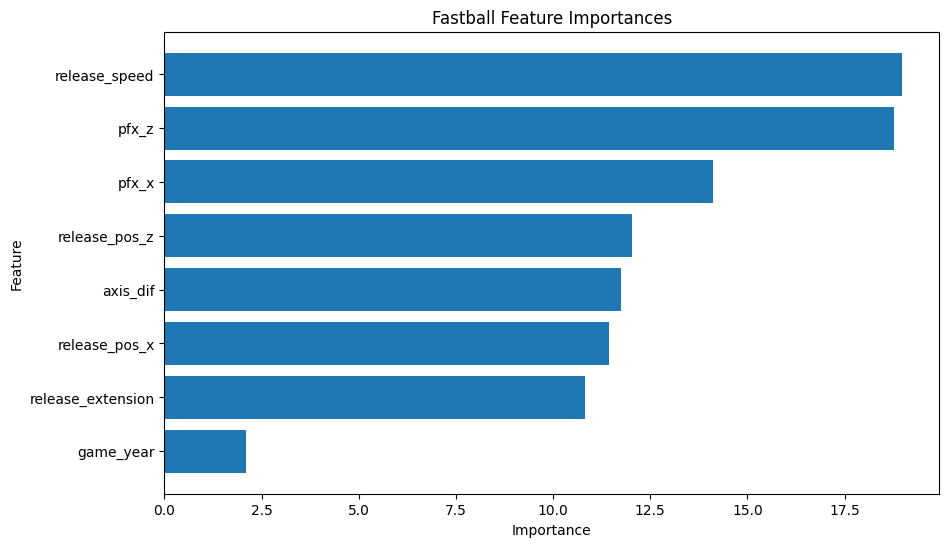

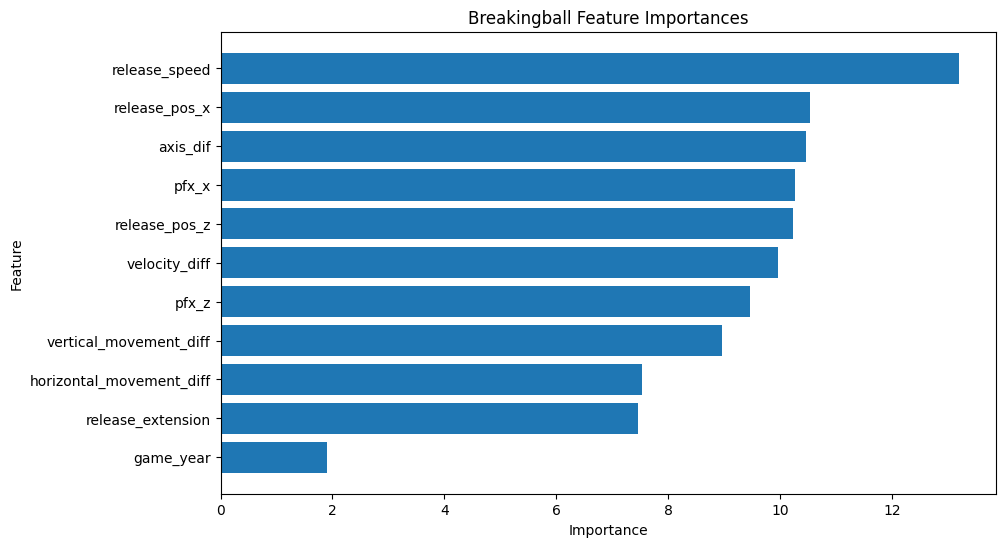

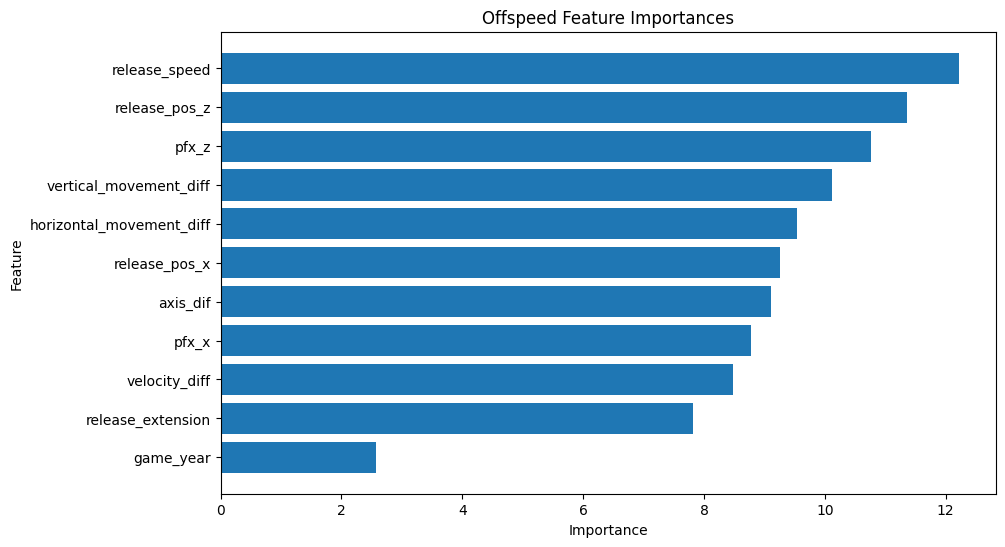

In [24]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
plot_feature_importances(fastball_model, fball_features, 'Fastball Feature Importances')
plot_feature_importances(breakingball_model, features, 'Breakingball Feature Importances')
plot_feature_importances(offspeed_model, features, 'Offspeed Feature Importances')


In [206]:
fastball_model.save_model('fastball_model_6_22_3model_data20_23.cbm')
breakingball_model.save_model('breakingball_model_6_22_3model_data20_23.cbm')
offspeed_model.save_model('offspeed_model_6_22_3model_data20_23.cbm')

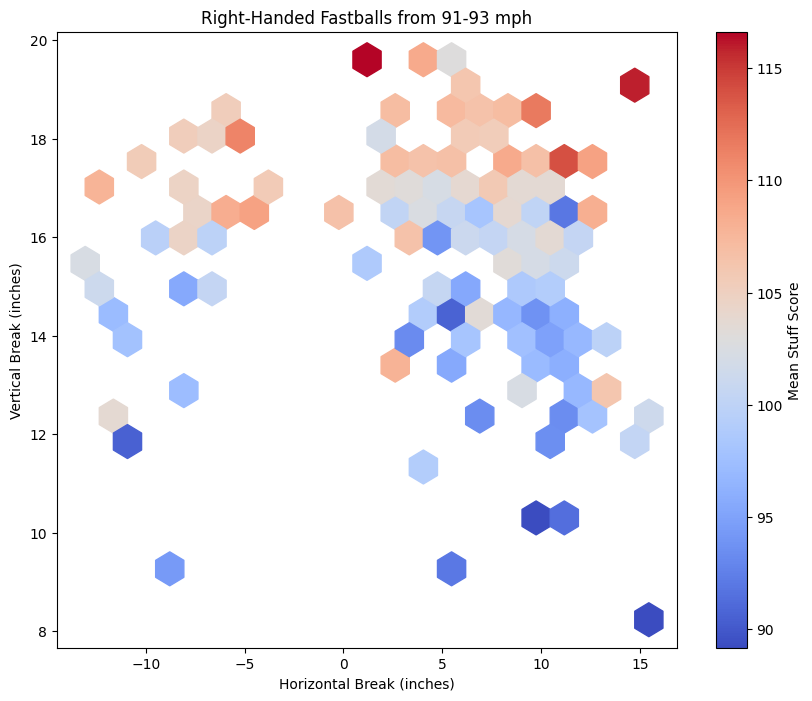

In [205]:
import matplotlib.pyplot as plt


# Filter data for fastballs within the 91-93 mph range
velocity_range = (95, 100)
filtered_data = fastball_graphic_data[(fastball_graphic_data['release_speed'] >= velocity_range[0]) & 
                                    (fastball_graphic_data['release_speed'] <= velocity_range[1])]

# Group by horizontal and vertical break and calculate the mean "stuff" score
grouped_data = filtered_data.groupby(['pfx_x', 'pfx_z'])['mean_scores'].mean().reset_index()

# Create hexbin plot
fig, ax = plt.subplots(figsize=(10, 8))

hb = ax.hexbin(grouped_data['pfx_x'], grouped_data['pfx_z'], C=grouped_data['mean_scores'], gridsize=20, cmap='coolwarm', reduce_C_function=np.mean)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Mean Stuff Score')

ax.set_xlabel('Horizontal Break (inches)')
ax.set_ylabel('Vertical Break (inches)')
ax.set_title('Right-Handed Fastballs from 91-93 mph')

plt.show()